# Uncertainty propagation for in silico mutants of the lactate homeostasis model

In [1]:
from model import *

import seaborn as sns
import matplotlib.pyplot as plt

# Set the font size
plt.rcParams.update({'font.size': 16, 'font.family': 'Arial'})
plt.rcParams.update({'lines.markeredgewidth': 1})


In [2]:
# Volume of distribution calculation 
# Glucose
F_circ = 100 * 25 * 1e-3 # umol/min 
C = 5.5 # mM
V_G = F_circ / C  * 14 

# NEFA 
F_circ = 100 * 25 * 1e-3 # umol/min
C = 0.5 # mM
V_F = F_circ / C * 10

# Lactate
F_circ = 150 * 25 * 1e-3 # umol/min
C = 0.75 # mM
V_L = F_circ / C * 3

# Print a table volume of distributions
print("Volume of distribution")
print(f"Glucose: {V_G:.2f} [mL]")
print(f"Lactate: {V_L:.2f} [mL]")
print(f"FFA: {V_F:.2f} [mL]")


Volume of distribution
Glucose: 6.36 [mL]
Lactate: 15.00 [mL]
FFA: 50.00 [mL]


In [3]:
# Test parameter estimation
p = reference_parameters()

In [4]:
import pandas as pd

# Function to run the knockout study
def run_ko_study(replicate = 1, concentration_noise=0.1, flux_noise=0.1, ki_noise=0.1, t_max=500):

    p = reference_parameters(concentration_noise, flux_noise, ki_noise=ki_noise)

    # Scenario 1: I0 = 0
    lactate_scenario0 = steady_state(p, t_max=t_max)

    # Scenario 1: 
    #GRPKO (K_F0_L = 1e3)
    p_scenario1 = change_parameters(p, e=[1e9], ix=["KI_F0_L"])
    lactate_scenario1 = steady_state(p_scenario1)
    
    # Scenario 2: I0 = 0
    p_scenario2 = change_parameters(p, e=[0.1], ix=["Imax"])
    lactate_scenario2 = steady_state(p_scenario2)

    # Scenario 3: Combination of I0 = 0 and GRPKO
    p_scenario3 = change_parameters(p, e=[0.1, 1e9], ix=["Imax", "KI_F0_L"])
    lactate_scenario3 = steady_state(p_scenario3)

    # Scenario 4: ko of lactate glycolysis feedback
    p_scenario4 = change_parameters(p, e=[1e9], ix=["KI_G_L"])
    lactate_scenario4 = steady_state(p_scenario4)

    # Scenario 5: Combination of I0 = 0 and ko of lactate glycolysis feedback
    p_scenario5 = change_parameters(p, e=[0.1, 1e9], ix=["Imax", "KI_G_L"])
    lactate_scenario5 = steady_state(p_scenario5)

    # Scenario 6: All three knockouts
    p_scenario6 = change_parameters(p, e=[0.1, 1e9, 1e9], ix=["Imax", "KI_G_L", "KI_F0_L"])
    lactate_scenario6 = steady_state(p_scenario6)

    # Scenario 7: HCAR + LactateKO
    p_scenario7 = change_parameters(p, e=[1e9,1e9], ix=["KI_G_L","KI_F0_L"])
    lactate_scenario7 = steady_state(p_scenario7)

    # Wrap into a datafroma with columns G, L, F, Scenario, replicate
    df_lactate = pd.DataFrame([lactate_scenario0, lactate_scenario1, lactate_scenario2, lactate_scenario3, 
                               lactate_scenario4, lactate_scenario5, lactate_scenario6, lactate_scenario7], columns=["G", "L", "F", "I"])
    df_lactate["Scenario"] = ["WT", "GRPKO",  "I0KO", "I0KO_GRPKO", "LactateKO", "I0KO_LactateKO", "TripleKO", "GRPKO_LactateKO"]
    df_lactate["Replicate"] = replicate
    df_lactate["Insulin"] = [1 ,1, 0.1, 0.1, 1, 0.1, 0.1, 1.0]

    # Calculate the fluxes for each scenario 
    fluxes_scenario0 = fluxes(lactate_scenario0, p)
    fluxes_scenario1 = fluxes(lactate_scenario1, p_scenario1)
    fluxes_scenario2 = fluxes(lactate_scenario2, p_scenario2)
    fluxes_scenario3 = fluxes(lactate_scenario3, p_scenario3)
    fluxes_scenario4 = fluxes(lactate_scenario4, p_scenario4)
    fluxes_scenario5 = fluxes(lactate_scenario5, p_scenario5)
    fluxes_scenario6 = fluxes(lactate_scenario6, p_scenario6)
    fluxes_scenario7 = fluxes(lactate_scenario7, p_scenario7)


    df_fluxes = pd.DataFrame([fluxes_scenario0, fluxes_scenario1, fluxes_scenario2, fluxes_scenario3,
                              fluxes_scenario4, fluxes_scenario5, fluxes_scenario6, fluxes_scenario7], columns=["vG0", "vF0", "vG", "vL", "vF"])

    # concat the data frames
    df_lactate = pd.concat([df_lactate, df_fluxes], axis=1)

    # Add the parameters
    df_parameters = pd.DataFrame([p, p_scenario1, p_scenario2, p_scenario3, p_scenario4, p_scenario5, p_scenario6, p_scenario7], columns=parameter_names)
    df_parameters["Scenario"] = ["WT", "GRPKO",  "I0KO", "I0KO_GRPKO", "LactateKO", "I0KO_LactateKO", "TripleKO", "GRPKO_LactateKO"]
    df_parameters["Replicate"] = replicate

    return df_lactate, df_parameters


In [5]:
# Run the study
n_replicates = 500
concentration_noise = 0.1
flux_noise = 0.0
ki_noise = 0.1

dfs = [run_ko_study(replicate = i, concentration_noise=concentration_noise, 
                    flux_noise=flux_noise, ki_noise=ki_noise, t_max=1000) for i in range(n_replicates)]
df = pd.concat([ d[0] for d in dfs])

df["I"] = insulin(df["G"], df["Insulin"], 0.0)

# Rescale to the experimental concentrations
df["G"] = df["G"] * 5.5
df["L"] = df["L"] * 0.75
df["F"] = df["F"] * 0.5

# Insulin scaling 
# insulin(1, 1, 0 ) = 0.2 ng/ml 
df["I"] = df["I"] * 0.2 / insulin(1, 1, 0 )

# Write out parameters
df_parameters = pd.concat([ d[1] for d in dfs])

parameter_scaling = {
    "kG": 1/tauG, "kL": 1/tauL,
    "kF": 1/tauF, "kR": 1.0,
    "vG0": 5.5/tauG*V_G, 
    "vF0": 0.5/tauF*V_F,
    "vE": 1.0,
    "a": 1.0,
    "KI_G_L": 0.75,
    "KI_F0_L": 0.75, 
    "KI_F0_I": 0.2 / insulin(1, 1, 0 ),
    "KA_G_I": 0.2 / insulin(1, 1, 0 ),
    "Imax": 1.0,
    "deltaI": 1.0
}

# Scale the parameters
df_parameters.loc[:,parameter_names] = df_parameters[parameter_names] * parameter_scaling
df_parameters.head()




C:\Users\dw6835\AppData\Local\Temp\ipykernel_60576\1141353992.py:41: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_parameters.loc[:,parameter_names] = df_parameters[parameter_names] * parameter_scaling


,kG,kL,kF,kR,vG0,vF0,vE,KI_G_L,KI_F0_L,KI_F0_I,KA_G_I,a,Imax,deltaI,Scenario,Replicate
0,0.07701,0.365643,0.78486,0.267731,2.5,9.54392,1.0,1.375907e+00,4.424261e+00,0.13471,2.580533,10.0,1.0,0.0,WT,0
1,0.07701,0.365643,0.78486,0.267731,2.5,9.54392,1.0,1.375907e+00,7.500000e+08,0.13471,2.580533,10.0,1.0,0.0,GRPKO,0
2,0.07701,0.365643,0.78486,0.267731,2.5,9.54392,1.0,1.375907e+00,4.424261e+00,0.13471,2.580533,10.0,0.1,0.0,I0KO,0
3,0.07701,0.365643,0.78486,0.267731,2.5,9.54392,1.0,1.375907e+00,7.500000e+08,0.13471,2.580533,10.0,0.1,0.0,I0KO_GRPKO,0
4,0.07701,0.365643,0.78486,0.267731,2.5,9.54392,1.0,7.500000e+08,4.424261e+00,0.13471,2.580533,10.0,1.0,0.0,LactateKO,0


In [7]:
# Write out the data
df.to_csv("data/simulation_data.csv", index=False)
df_parameters.to_csv("data/parameters.csv", index=False)

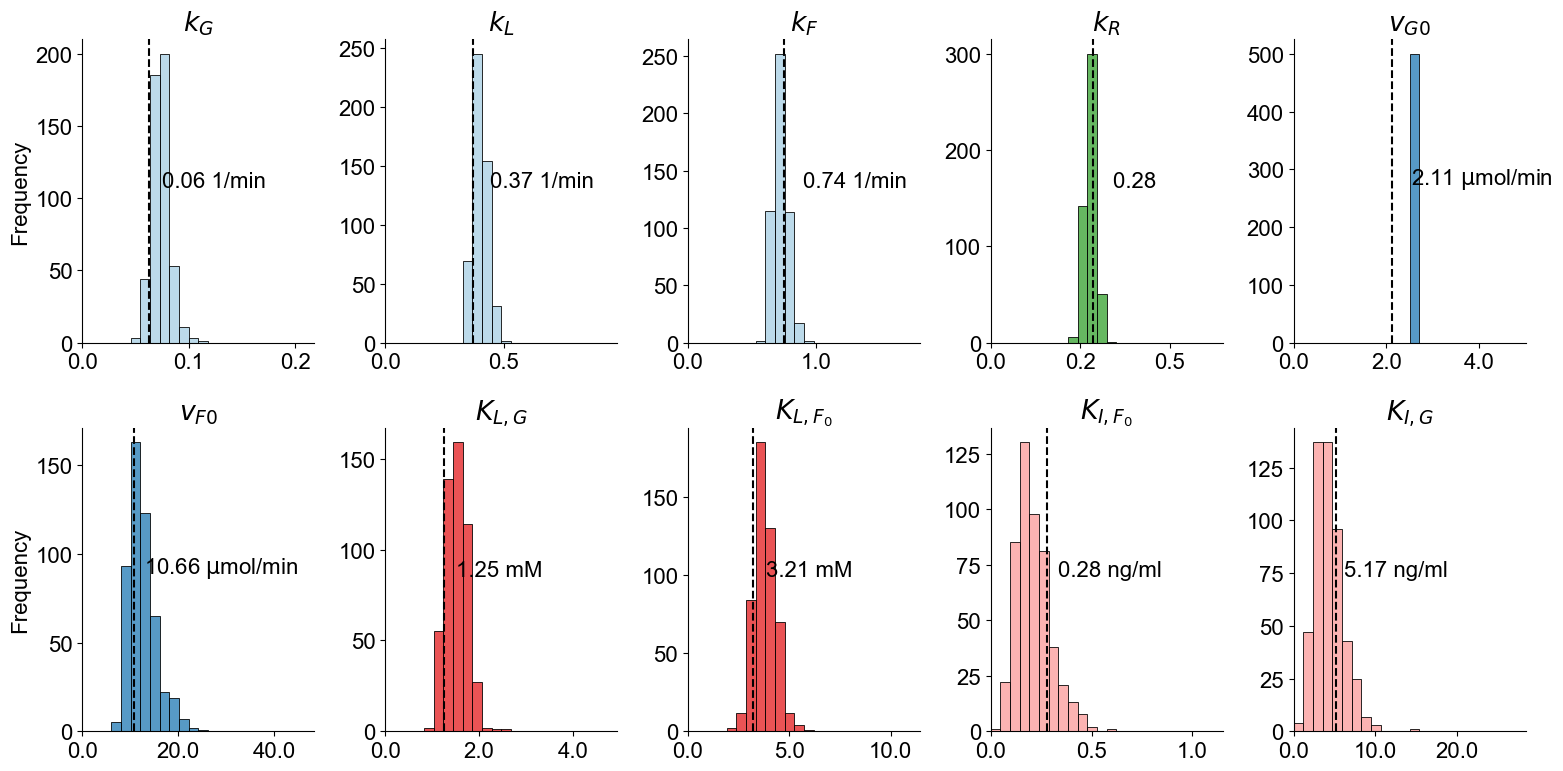

In [8]:
# Plot parameter populations 
parameter_order = [
    "kG", "kL", "kF", "kR", "vG0", "vF0", "KI_G_L", "KI_F0_L", "KI_F0_I", "KA_G_I", 
]
parameter_description = {
    "kG": "$k_G$ Glycolyis propensity action",
    "kL": "$k_L$ Lactate buring propensity",
    "kF": "$k_F$ Fatty acid buring propensity",
    "kR": "Re-esterification propensity",
    "vG0": "$V_{G0}$ Liver glucose production",
    "vF0": "$V_{F0}$ Maximal fatty-acid release",
    "vE": "$V_E$ $Energy production rate",
    "KI_G_L": "$K_{L,G}$ Lactate inhibition of glycolysis",
    "KI_F0_L": "$K_{L,F_0}$ Lactate inhibition of lipolysis",
    "KI_F0_I": "$K_{I,F_0}$ Insulin inhibition of lipolysis",
    "KA_G_I": "$K_{I,G}$ Insulin activation of glycolysis",
    "Imax": "Maximal insulin production",
    "deltaI": "Insulin degradation"
}

parameter_symbol = {
    "kG": "$k_G$", "kL": "$k_L$",
    "kF": "$k_F$", "kR": "$k_R$",
    "vG0": "$v_{G0}$", "vF0": "$v_{F0}$",
    "vE": "$V_E$", "KI_G_L": "$K_{L,G}$",
    "KI_F0_L": "$K_{L,F_0}$", "KI_F0_I": "$K_{I,F_0}$",
    "KA_G_I": "$K_{I,G}$", "Imax": "$I_{max}$",
    "deltaI": "$\delta_I$"
}

palette = sns.color_palette("Paired")
parameter_color = {
    "kG": palette[0], "kL": palette[0],
    "kF": palette[0], "kR": palette[3],
    "vG0": palette[1], "vF0": palette[1],
    "vE": palette[5], "KI_G_L": palette[5],
    "KI_F0_L": palette[5], 
    "KI_F0_I": palette[4],
    "KA_G_I": palette[4], 
    "Imax": palette[5],
    "deltaI": palette[5]

}


parameter_units = { 
    "kG": "1/min", "kL": "1/min",
    "kF": "1/min", "kR": "",
    "vG0": "$\mathrm{\mu}$mol/min",
    "vF0": "$\mathrm{\mu}$mol/min",
    "vE": "mmol/min",
    "KI_G_L": "mM",
    "KI_F0_L": "mM",
    "KI_F0_I": "ng/ml",
    "KA_G_I": "ng/ml",
    "Imax": "ng/ml",
    "deltaI": "1/min"
}

f, ax = plt.subplots(2,5, figsize=(16,8))
for i, pn in enumerate(parameter_order):

    # Make the bins from 0 to relveant value
    bins = np.linspace(0,2*df_parameters[df_parameters.Scenario == 'WT'][pn].max(), 25)

    sns.histplot(df_parameters[df_parameters.Scenario == 'WT'], x=pn, ax=ax.flatten()[i], bins=bins, color=parameter_color[pn])
    # Plot vertical line for the reference value
    j = parameter_names.index(pn)
    ax.flatten()[i].axvline(p[j]*parameter_scaling[pn], color='black', linestyle='--')
    # Annotate the horizaontal line
    max_height = ax.flatten()[i].get_ylim()[1]
    ax.flatten()[i].text(p[j]*parameter_scaling[pn]*1.2, 0.5 * max_height, 
                         f'{p[j]*parameter_scaling[pn]:.2f} {parameter_units[pn]}', verticalalignment='bottom')    
    # despine the axes
    sns.despine()

    # Remove the y-axis label
    ax.flatten()[i].set_ylabel('')
    ax.flatten()[i].set_xlabel('')
    ax.flatten()[i].set_title(parameter_symbol[pn]) 

    # Make nice x-axis ticks 
    # make x min = 0 
    ax.flatten()[i].set_xlim(bins[0], bins[-1])
    ax.flatten()[i].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))


# Put y label on the left
for i in [0,5]:
    ax.flatten()[i].set_ylabel('Frequency')
    ax.flatten()[i].yaxis.set_label_position("left")
    ax.flatten()[i].yaxis.tick_left()

plt.tight_layout()

plt.savefig("./output/parameter_histograms.svg")
plt.show()




In [9]:
# Compute relative concentrations to WT per replicate
for r in df["Replicate"].unique():    
    df.loc[df["Replicate"]==r, "I_relative"] = df.loc[df["Replicate"]==r, "I"] / df.loc[(df["Replicate"]==r) & (df["Scenario"]=="WT"), "I"].values[0]
    df.loc[df["Replicate"]==r, "F_relative"] = df.loc[df["Replicate"]==r, "F"] / df.loc[(df["Replicate"]==r) & (df["Scenario"]=="WT"), "F"].values[0]
    df.loc[df["Replicate"]==r, "G_relative"] = df.loc[df["Replicate"]==r, "G"] / df.loc[(df["Replicate"]==r) & (df["Scenario"]=="WT"), "G"].values[0]
    df.loc[df["Replicate"]==r, "L_relative"] = df.loc[df["Replicate"]==r, "L"] / df.loc[(df["Replicate"]==r) & (df["Scenario"]=="WT"), "L"].values[0]


In [10]:
df_HCAR1_1 = df[df["Scenario"] == "GRPKO"].copy()
df_HCAR1_2 = df[df["Scenario"] == "I0KO_GRPKO"].copy()

# Compute trelative concetration relative to wt HCAR1 + insulin depletion
for r in df_HCAR1_2["Replicate"].unique():    
    df_HCAR1_2.loc[df_HCAR1_2["Replicate"]==r, "I_relative"] = df.loc[df["Replicate"]==r, "I"] / df.loc[(df["Replicate"]==r) & (df["Scenario"]=="I0KO"), "I"].values[0]
    df_HCAR1_2.loc[df_HCAR1_2["Replicate"]==r, "F_relative"] = df.loc[df["Replicate"]==r, "F"] / df.loc[(df["Replicate"]==r) & (df["Scenario"]=="I0KO"), "F"].values[0]
    df_HCAR1_2.loc[df_HCAR1_2["Replicate"]==r, "G_relative"] = df.loc[df["Replicate"]==r, "G"] / df.loc[(df["Replicate"]==r) & (df["Scenario"]=="I0KO"), "G"].values[0]
    df_HCAR1_2.loc[df_HCAR1_2["Replicate"]==r, "L_relative"] = df.loc[df["Replicate"]==r, "L"] / df.loc[(df["Replicate"]==r) & (df["Scenario"]=="I0KO"), "L"].values[0]

df_HCAR1 = pd.concat([df_HCAR1_1, df_HCAR1_2])



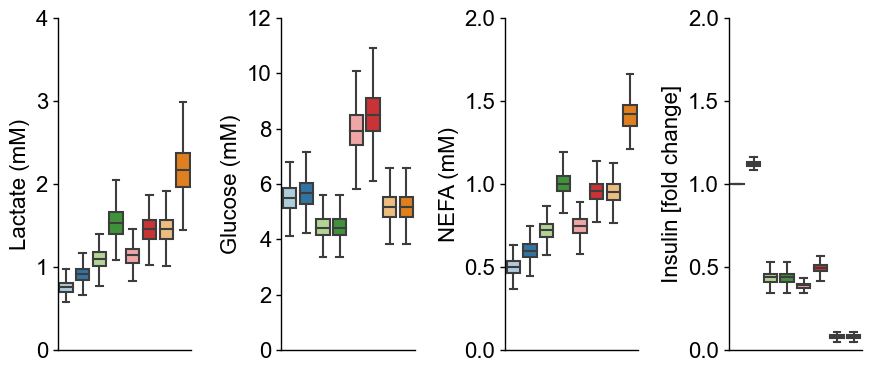

In [11]:
##############################################
# Figure S6 E                                 #
##############################################

# Define the custom color palette
#custom_palette = ['grey', 'yellow', 'blue', 'green', 'red', 'purple', 'orange', 'brown']
custom_palette = sns.color_palette("Paired")

# Make a figure with three subplots
fig, axs = plt.subplots(1, 4, figsize=(9, 4))

order = ["WT", "GRPKO", "LactateKO", "GRPKO_LactateKO", "I0KO", "I0KO_GRPKO", "I0KO_LactateKO", "TripleKO"]

s1 = sns.boxplot(data=df, x='Scenario', y='L', ax=axs[0], palette=custom_palette, showfliers=False, order=order)
axs[0].set_ylabel('Lactate (mM)')
axs[0].set_xticklabels([])  # Remove x-axis labels
axs[0].set_xticks([])  # Remove x-axis ticks
axs[0].set_xlabel('')  # Remove x-axis labels
axs[0].set_ylim(0, 4)

s2 = sns.boxplot(data=df, x='Scenario', y='G', ax=axs[1], palette=custom_palette, showfliers=False, order=order)
axs[1].set_ylabel('Glucose (mM)')
axs[1].set_xticklabels([])  # Remove x-axis labels
axs[1].set_xticks([])  # Remove x-axis ticks
axs[1].set_xlabel('')  # Remove x-axis labels
axs[1].set_ylim(0, 12)

s3 = sns.boxplot(data=df, x='Scenario', y='F', ax=axs[2], palette=custom_palette, showfliers=False, order=order)
axs[2].set_ylabel('NEFA (mM)')
axs[2].set_xticklabels([])  # Remove x-axis labels
axs[2].set_xticks([])  # Remove x-axis ticks
axs[2].set_xlabel('')  # Remove x-axis labels
axs[2].set_ylim(0, 2)

s4 = sns.boxplot(data=df, x='Scenario', y='I_relative', ax=axs[3], palette=custom_palette, showfliers=False, order=order)
axs[3].set_ylabel('Insulin [fold change]')
axs[3].set_xticklabels([])  # Remove x-axis labels
axs[3].set_xticks([])  # Remove x-axis ticks
axs[3].set_xlabel('')  # Remove x-axis labels
axs[3].set_ylim(0, 2)
# Set y-ticks to start from 0

for ax in axs:
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axs[0].tick_params(width=1.0)
axs[1].tick_params(width=1.0)
axs[2].tick_params(width=1.0)
axs[3].tick_params(width=1.0)

# Adjust the spacing between bars and table
plt.tight_layout()

# Save the plot as a high-resolution image
plt.savefig('./output/concentrations_steady_state_ko.svg')

plt.show()


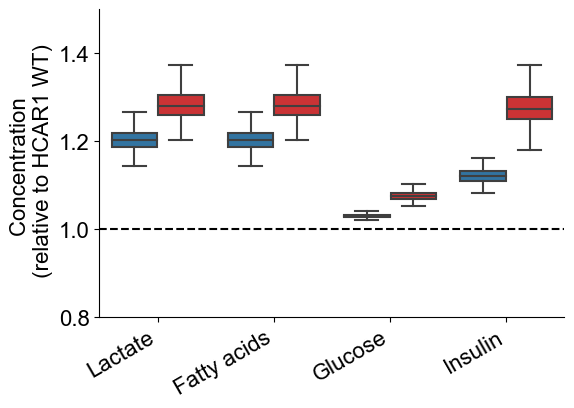

In [12]:
##############################################
# Figure 6 I                                 #
##############################################

# Plot relative concentrations for the HCAR1 mutant
# Preprocess data for seaborn 
df_temp = df_HCAR1[['Scenario','Replicate','I_relative', 'F_relative', 'G_relative', 'L_relative']]
df_temp = df_temp.melt(id_vars=['Scenario','Replicate'])

import seaborn as sns
import matplotlib.pyplot as plt

# Set the font size
plt.rcParams.update({'font.size': 16, 'font.family': 'Arial'})
plt.rcParams.update({'lines.markeredgewidth': 1})

# Define the custom color palette
#custom_palette = ['grey', 'yellow', 'blue', 'green', 'red', 'purple', 'orange', 'brown']
custom_palette = sns.color_palette("Paired")
# Make a figure with three subplots
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

order = ['L_relative','F_relative','G_relative','I_relative']
# Barplot with error bars
#sns.barplot(data=df_temp, x='variable', y='value', hue='Scenario', palette=[custom_palette[1], custom_palette[5]],
#             errorbar='pi', order=order, hue_order=['GRPKO', 'I0KO_GRPKO'])
sns.boxplot(data=df_temp, x='variable', y='value', hue='Scenario', palette=[custom_palette[1], custom_palette[5]], showfliers=False, order=order, hue_order=['GRPKO', 'I0KO_GRPKO'])

# Horizontal line at 1
plt.axhline(1, color='black', linestyle='--')

# No legend
plt.legend().remove()   
# Set y-ticks to start from 0
plt.ylim(0.8,1.5)
# Y-axis label
plt.xlabel('')
plt.ylabel('Concentration \n (relative to HCAR1 WT)')

sns.despine()

# xticks
plt.xticks([0,1,2,3], ['Lactate', 'Fatty acids', 'Glucose', 'Insulin'], rotation=30, ha='right')

plt.savefig('./output/concentrations_relative_HCAR1.svg')
plt.show()

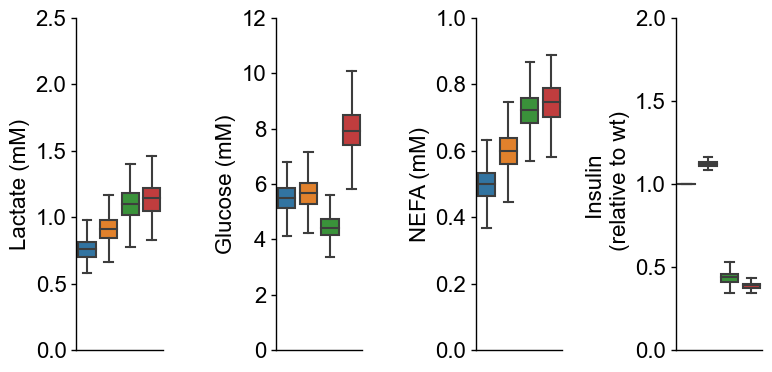

In [13]:
##############################################
# Figure 6 H                                 #
##############################################

import seaborn as sns
import matplotlib.pyplot as plt

# Set the font size
plt.rcParams.update({'font.size': 16, 'font.family': 'Arial'})
plt.rcParams.update({'lines.markeredgewidth': 1})

# Define the custom color palette
#custom_palette = ['grey', 'yellow', 'blue', 'green', 'red', 'purple', 'orange', 'brown']
custom_palette = sns.color_palette("tab10")

# Make a figure with three subplots
fig, axs = plt.subplots(1, 4, figsize=(8, 4))

order = ["WT", "GRPKO", "LactateKO", "I0KO",]

df = df.loc[df["Scenario"].isin(order)]

s1 = sns.boxplot(data=df, x='Scenario', y='L', ax=axs[0], palette=custom_palette, showfliers=False, order=order)
axs[0].set_ylabel('Lactate (mM)')
axs[0].set_xticklabels([])  # Remove x-axis labels
axs[0].set_xticks([])  # Remove x-axis ticks
axs[0].set_xlabel('')  # Remove x-axis labels
axs[0].set_ylim(0, 2.5)

s2 = sns.boxplot(data=df, x='Scenario', y='G', ax=axs[1], palette=custom_palette, showfliers=False, order=order)
axs[1].set_ylabel('Glucose (mM)')
axs[1].set_xticklabels([])  # Remove x-axis labels
axs[1].set_xticks([])  # Remove x-axis ticks
axs[1].set_xlabel('')  # Remove x-axis labels
axs[1].set_ylim(0, 12)

s3 = sns.boxplot(data=df, x='Scenario', y='F', ax=axs[2], palette=custom_palette, showfliers=False, order=order)
axs[2].set_ylabel('NEFA (mM)')
axs[2].set_xticklabels([])  # Remove x-axis labels
axs[2].set_xticks([])  # Remove x-axis ticks
axs[2].set_xlabel('')  # Remove x-axis labels
axs[2].set_ylim(0, 1)

s4 = sns.boxplot(data=df, x='Scenario', y='I_relative', ax=axs[3], palette=custom_palette, showfliers=False, order=order)
axs[3].set_ylabel('Insulin \n (relative to wt)')
axs[3].set_xticklabels([])  # Remove x-axis labels
axs[3].set_xticks([])  # Remove x-axis ticks
axs[3].set_xlabel('')  # Remove x-axis labels
axs[3].set_ylim(0, 2)
# Set y-ticks to start from 0

for ax in axs:
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axs[0].tick_params(width=1.0)
axs[1].tick_params(width=1.0)
axs[2].tick_params(width=1.0)
axs[3].tick_params(width=1.0)

# Adjust the spacing between bars and table
plt.tight_layout()

# Save the plot as a high-resolution image
plt.savefig('./output/concentrations_steady_state_ko_reduced.svg')

plt.show()
